In [32]:
import os
import re
from torchvggish import vggish, vggish_input
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

In [60]:
MUSIC_DIR="music/sampled/"
EMBEDDING_MODEL = vggish()
EMBEDDING_MODEL.eval()
SONG_LENGTH = 30 # length of samples
SAMPLES_PER_CAT=60

In [63]:
path1 = MUSIC_DIR+"cat_philipp/Synestia, Disembodied Tyrant - Winter.wav"
path2 = MUSIC_DIR+"cat_jonas/Billy Talent - Fallen Leaves.wav"

name1 = path1.split("/")[3]
name2 = path2.split("/")[3]

song1,sr = librosa.load(path1)
song2,sr = librosa.load(path2)

print(name1)
ipd.display(ipd.Audio(data=song1, rate=sr))
print(name2)
ipd.display(ipd.Audio(data=song2, rate=sr))

Synestia, Disembodied Tyrant - Winter.wav


Billy Talent - Fallen Leaves.wav


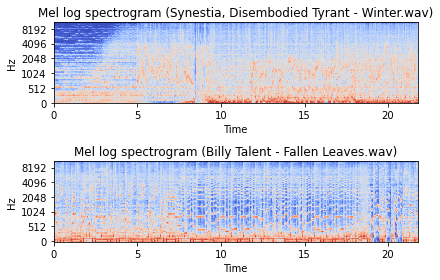

In [58]:
def getLogMelSpec(path):
    song,sr = librosa.load(path,sr=16000,mono=True)
    song_spec=librosa.feature.melspectrogram(y=song, sr=sr,window="hann")
    return np.log(song_spec+0.01),sr

song1_spec_data,sr1=getLogMelSpec(path1)
song2_spec_data,sr2=getLogMelSpec(path2)

fig, (ax1,ax2) = plt.subplots(nrows=2)

img = librosa.display.specshow(song1_spec_data, y_axis='mel', x_axis='time', ax=ax1)
ax1.set(title=f'Mel log spectrogram ({name1})');
img = librosa.display.specshow(song2_spec_data, y_axis='mel', x_axis='time', ax=ax2)
ax2.set(title=f'Mel log spectrogram ({name2})');
fig.tight_layout()

In [8]:
def readFolder2Embedding(path):

    songs = os.listdir(path)

    songs= np.random.choice(songs,size=60,replace=False)

    # vggish output embedding has length 128
    data = np.zeros((SAMPLES_PER_CAT, SONG_LENGTH*128))
    labels = []

    for i, song in enumerate(songs):
        print(f"Learning Embedding for {song}")
        embedding = EMBEDDING_MODEL.forward(
            vggish_input.wavfile_to_examples(path+"/"+song))
        # normalize length, convert to numpy array and flatten the feature array
        converted_embedding = embedding.detach().numpy()[
            :SONG_LENGTH, :].flatten()
        data[i, :] = converted_embedding
        # get label/category name from directory name
        labels.append(re.match(r".*cat_(.*)", path)[1])
    return data, labels

In [9]:
def readIn():
    directories = sorted(os.listdir(MUSIC_DIR))
    data = np.empty((0, SONG_LENGTH*128))
    label = []
    for directory in directories:
        dir_data, dir_label = readFolder2Embedding(
            MUSIC_DIR+directory)
        data = np.concatenate((data, dir_data), axis=0)
        label += dir_label
    print("All data read in successfully!")
    return data, label

In [10]:
def classify(classifier, filepath):
    print("Predicting label for" + filepath + "...")
    embedding = EMBEDDING_MODEL.forward(vggish_input.wavfile_to_examples(filepath))
    converted_embedding = embedding.detach().numpy()[
        :SONG_LENGTH, :].flatten()
    return classifier.predict(converted_embedding.reshape(1, -1))

In [11]:
def test(classifier, data, labels):
    predictions=[]
    for sample in data:
        predictions.append(classifier.predict(sample.reshape(1, -1)))
    return accuracy_score(labels,predictions)

In [12]:
data, label = readIn()

Learning Embedding for Billy Talent - Red Flag.wav
Learning Embedding for blink-182 - No Heart To Speak Of.wav
Learning Embedding for blink-182 - Going Away To College.wav
Learning Embedding for Linkin Park - In the End.wav
Learning Embedding for Kraftklub - Schüsse in die Luft.wav
Learning Embedding for Foo Fighters - Long Road To Ruin.wav
Learning Embedding for blink-182 - First Date.wav
Learning Embedding for blink-182 - Pin the Grenade.wav
Learning Embedding for My Chemical Romance - Famous Last Words.wav
Learning Embedding for Linkin Park - CASTLE OF GLASS.wav
Learning Embedding for Oasis - Don_t Look Back In Anger.wav
Learning Embedding for blink-182 - ANTHEM PART 3.wav
Learning Embedding for blink-182 - Up All Night.wav
Learning Embedding for AWOLNATION - Kill Your Heroes.wav
Learning Embedding for blink-182 - Down.wav
Learning Embedding for Bakkushan - Deine Helden sind tot.wav
Learning Embedding for Kraftklub - Chemie Chemie Ya - Geil und Gestört Edit.wav
Learning Embedding fo

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33,stratify=label)

classifier=DecisionTreeClassifier(max_depth=20)
classifier.fit(x_train, y_train)
print("Training successful")

Training successful


In [32]:
print("Accuracy:"+ str(test(classifier,x_test, y_test)))

Accuracy:0.85
